In [19]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
PATH = r"C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"

In [20]:
data = jnp.load(PATH + "kdv.npz")

In [21]:
class UnitGaussianNormalizer:
    def __init__(self, x, eps=0.00001):
        self.mean = jnp.mean(x,0)
        self.std = jnp.std(x,0)
        self.eps = eps

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return (x * (self.std + self.eps)) + self.mean

In [22]:
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

In [23]:
import matplotlib.pyplot as plt

In [24]:
print(u_train[3])

[[2.87894921e-04 2.53462576e-04 2.23420010e-04 ... 3.72288810e-04
  3.27285141e-04 2.87894921e-04]
 [2.94083827e-04 2.58814269e-04 2.28012520e-04 ... 3.80454364e-04
  3.34406126e-04 2.94083827e-04]
 [3.00305332e-04 2.64214117e-04 2.32719315e-04 ... 3.88780790e-04
  3.41621866e-04 3.00305332e-04]
 ...
 [1.54177532e-01 1.25783299e-01 1.02630558e-01 ... 2.31369747e-01
  1.88934571e-01 1.54177532e-01]
 [1.70041304e-01 1.38655858e-01 1.13052458e-01 ... 2.55234599e-01
  2.08427882e-01 1.70041304e-01]
 [1.87647607e-01 1.52961885e-01 1.24648459e-01 ... 2.81626487e-01
  2.30027545e-01 1.87647607e-01]]


In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [26]:
num_nan = 0
for i in range(35, len(u_train)):
    if jnp.isnan(u_train[i,-1,0]):
        num_nan +=1
        print(i)
        
print(num_nan)

0


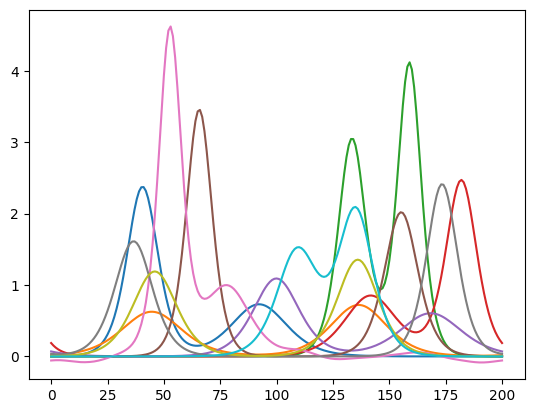

In [27]:
for i in range(10):
    plt.plot(u_train[i,-1])

In [28]:
t[::4]

Array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
       0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
       0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28,
       1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72,
       1.76, 1.8 , 1.84, 1.88, 1.92, 1.96, 2.  ], dtype=float64)

In [29]:
from jax import random

In [49]:
λ = jnp.ones(len(u_train[0]))

In [50]:
t_idx = random.randint(random.key(0), (8,), 0, 100)

(8,)

In [63]:
u_gt = jnp.arange(8*100*200).reshape(8,100,200)
λ = jnp.ones(100)
print((u_gt*λ[:,None]).shape)

(8, 100, 200)


In [ ]:
def Dx(y, dx, order = 4):
    """Assumes periodic boundary conditions"""
    y_p_1 = jnp.roll(y, shift=-1)
    y_m_1 = jnp.roll(y, shift=1)
    if order == 2:
        return (y_p_1 - y_m_1) / (2 * dx)
    else:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        return (-y_p_2 + 8*y_p_1 - 8*y_m_1 + y_m_2)/(12*dx)

In [ ]:
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = -η/6*u**3 + 0.5*γ**2*Dx(u, dx)**2
    return dx*jnp.sum(integrand, axis=0)

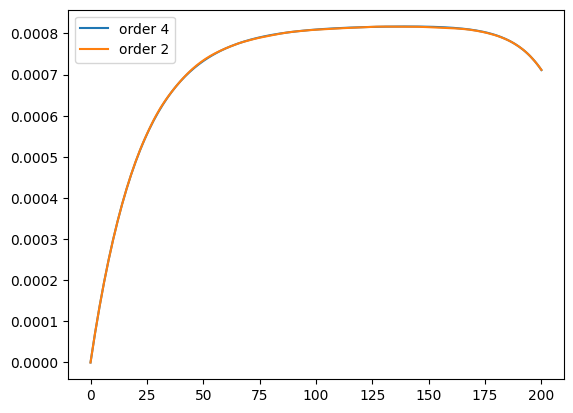

In [13]:
args = {"η": 6., "γ": 1., "dx": x[1]-x[0]}
Hs = jax.vmap(H_energy, (0, None))(u_train[800], args)
Hs2 = jax.vmap(H_energy, (0, None))(u_train2[800], args)
plt.plot(Hs-Hs[0], label="order 4")
plt.plot(Hs2-Hs2[0], label="order 2")
plt.legend()

In [108]:
from jax import random

In [128]:
def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    c1, c2 = 2, 2
    d1, d2 = 0.5, 0.5
    
    u0 = 2 * c1**2 * sech(c1 * ((x+P/2-d1*P) % P - P/2))**2
    u0 += 2 * c2**2 * sech(c2 * ((x+P/2-d2*P) % P - P/2))**2
    return u0

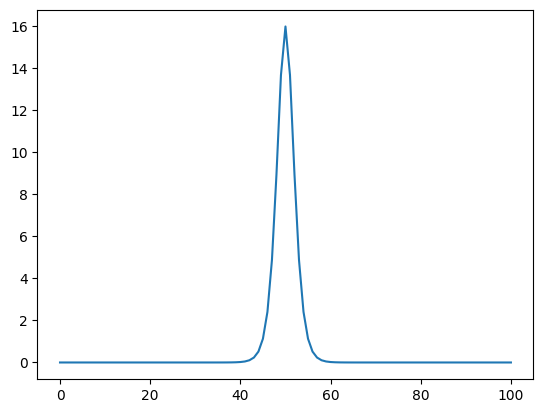

In [129]:
plt.plot(initial_condition_kdv(x, random.key(7)))

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as random
import optimistix as optx
from functools import partial
import equinox as eqx
key = random.key(0)
import argparse

#################PARAMETERS####################

η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 1000 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 400 # N+1 time points 

t0 = 0.0 # initial time
t_final = 2.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ, "dx" : dx, "order" : 4}

###############INITIAL CONDITION####################

def sech(x): return 1/jnp.cosh(x)

def initial_condition_kdv(x, key, η=6., P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    u0 = (-6./-η)*2 * c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    u0 += (-6./-η)*2 * c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return u0

#############SPATIAL DERIVATIVES####################
def Dx(y, dx, order = 4):
    """Assumes periodic boundary conditions"""
    y_p_1 = jnp.roll(y, shift=-1)
    y_m_1 = jnp.roll(y, shift=1)
    if order == 2:
        return (y_p_1 - y_m_1) / (2 * dx)
    else:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        return (-y_p_2 + 8*y_p_1 - 8*y_m_1 + y_m_2)/(12*dx)
        

def Dxx(y, dx, order = 4):
    """Assumes periodic boundary conditions"""
    y_p_1 = jnp.roll(y, shift=-1)
    y_m_1 = jnp.roll(y, shift=1)
    
    if order == 2:
        return (y_p_1 - 2 * y + y_m_1) / dx**2
    else:
        y_p_2 = jnp.roll(y, shift=-2)
        y_m_2 = jnp.roll(y, shift=2)
        return (-y_p_2+16*y_p_1-30*y+16*y_m_1-y_m_2)/(12*dx**2)

#############SOLVERS####################

@partial(jax.jit, static_argnums=(0,))
def implicit_midpoint(f, u0, dt, t, args, rtol, atol):
    def step(carry, tn):
        un, dt = carry

        fn = f(tn, un, args)

        # The update should satisfy y1 = eq(y1), i.e. y1 is a fixed point of fn
        def eq(u, args):
            return un + dt * f(tn+0.5*dt, 0.5*(un+u), args)

        u_next_euler = un + dt * fn # Euler step as guess

        solver = optx.Newton(rtol, atol)
        u_next = optx.fixed_point(eq, solver, u_next_euler, args).value  # satisfies y1 == fn(y1)
        return (u_next, dt), un
    
    _, u_arr = jax.lax.scan(step, (u0, dt), t)
    return u_arr


@partial(jax.jit, static_argnums=(0,))
def implicit_gauss_legendre(f, u0, dt, t, args, rtol, atol):
    """
    Integrates the ODE system using the 2-stage Gauss-Legendre method.
    Implementation follows "IV.8 Implementation of Implicit Runge-Kutta Methods" in 
    "Solving Ordinary Differential Equations II" by Hairer and Wanner

    Args:
      f: The right-hand side function of the ODE system.
      u0: Initial condition.
      dt: Time step.
      t: Array of time points.
      args: Additional arguments to pass to f.
      rtol: Relative tolerance for the nonlinear solver.
      atol: Absolute tolerance for the nonlinear solver.

    Returns:
      An array of solution values at the given time points.
    """
    c = jnp.array([0.5 - jnp.sqrt(3)/6, 0.5 + jnp.sqrt(3)/6])
    A = jnp.array([[0.25, 0.25 - jnp.sqrt(3)/6], 
                   [0.25 + jnp.sqrt(3)/6, 0.25]])
    d = jnp.array([-jnp.sqrt(3), jnp.sqrt(3)])
    
    def step(carry, tn): 
        un, z_guess = carry
        #u_next = implicit_gauss_legendre_step(f, tn, un, dt, args, rtol, atol)
        def eq(z, args):
            z1 = dt*(A[0,0] * f(tn + c[0]*dt, un + z[0], args) + A[0,1]*f(tn + c[1]*dt, un + z[1], args))
            z2 = dt*(A[1,0] * f(tn + c[0]*dt, un + z1, args) + A[1,1]*f(tn + c[1]*dt, un + z[1], args))
            return jnp.array([z1, z2])
        
        solver = optx.Newton(rtol, atol)
        z_next = optx.fixed_point(eq, solver, z_guess, args, max_steps=50).value
        u_next = un + jnp.dot(d, z_next)
        
        # Guess for the next step
        q = lambda x: z_next[0]*(x-c[1])/(c[0]-c[1])*x/c[0] + z_next[1]*(x-c[0])/(c[1]-c[0])*x/c[1]
        z_guess = jnp.array([q(1+c[0])+un-u_next, q(1+c[1])+un-u_next])
        return (u_next, z_guess), un

    z_guess = jnp.zeros((2, u0.shape[0]))
    _, u_arr = jax.lax.scan(step, (u0, z_guess), t)
    return u_arr

#############EQUATION####################
def f(t, u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    return Dx(-η/2*u**2 - γ**2 * Dxx(u, dx), dx)

#############HAMILTONIANS################
def H_energy(u, args):
    η, γ, dx = args["η"], args["γ"], args["dx"]
    integrand = -η/6*u**3 - 0.5*γ**2*Dx(u)**2
    return dx*jnp.sum(integrand)

def H_mass(u, args):
    return dx * jnp.sum(u)

def H_momentum(u, args):
    return dx * jnp.sum(u**2)


#############SOLVING####################



In [ ]:
NUM_SAMPLES = 1000
atol, rtol = 1e-6, 1e-6
keys = random.split(random.key(1), NUM_SAMPLES)
u0 = initial_condition_kdv(x, keys[663], η, P)
res2 = implicit_gauss_legendre(f, u0, dt, t, args, rtol, atol)

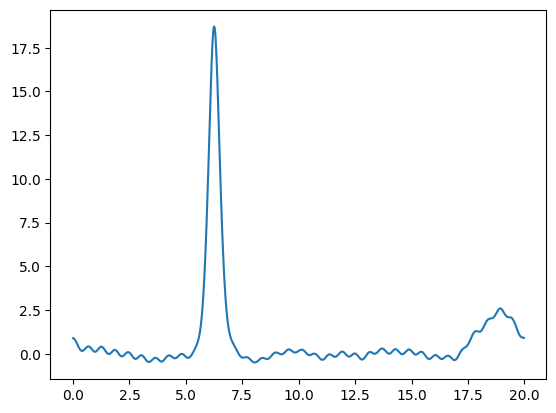

In [272]:
plt.plot(x, res2[-1])